# GA4GH GitHub Commit Statistics

Expects github-stats-summary.tsv to exist already; see Makefile for generation

This code counts commits in ga4gh-org repos only. Repos outside the org, and no comments and issues are counted anywhere.

## Plots to make
- repos over time
- [ ] num committers, per repo
- [ ] num commits, per repo

## Committers
- [ ] contributor longevity
- [ ] commits


## Bugs
- [ ] email addresses are not transformed to unique humans.  e.g., reece@harts.net and reecehart@gmail.com are the same people, 102165525+wesleygoar@users.noreply.github.com and wesley.goar@nationwidechildrens.org are the same people, and 49699333+dependabot[bot]@users.noreply.github.com is a bot


## Setup and read data

In [1]:
import datetime
from datetime import datetime

import pandas as pd
import pytz
import scipy

stats_fn = "github-stats-summary.tsv"
forks_fn = "forks"
now = datetime.now(tz=pytz.UTC)

fork_repos = set(open(forks_fn).read().split())

In [6]:
commits = pd.read_csv(
    stats_fn,
    delimiter="\t",
    parse_dates=["ts"],
    keep_default_na=False,
    converters={
        "files_changed": lambda x: int(x or 0),
        "insertions": lambda x: int(x or 0),
        "deletions": lambda x: int(x or 0),
    },
)

# remove repos that are forks of authoritative repos elsewhere
commits = commits[~commits["repo"].isin(fork_repos)]
_ = commits.pop("hash")
_ = commits.pop("committer_email")

In [7]:
commits["ts_ym"] = commits["ts"].apply(lambda ts: ts.strftime("%Y-%m"))
commits.insert(2, "ts_ym", commits.pop("ts_ym"))   # move ts_YM to right of ts
commits["ts_y"] = commits["ts"].apply(lambda ts: ts.strftime("%Y"))
commits.insert(2, "ts_y", commits.pop("ts_y"))     # move ts_Y to right of ts
commits.head()

,repo,ts,ts_y,ts_ym,author_email,files_changed,insertions,deletions,subject
0,ga4gh/ADA-M,2019-01-21 12:41:00-05:00,2019,2019-01,mirocupak@gmail.com,1,9,30,Remove released build dependencies
1,ga4gh/ADA-M,2018-11-28 17:04:29-05:00,2018,2018-11,fjeanson@yahoo.com,1,1,1,fixed wagger parser version error
2,ga4gh/ADA-M,2018-11-28 16:57:17-05:00,2018,2018-11,fjeanson@yahoo.com,1,1,1,fixed swagger-core clone version
3,ga4gh/ADA-M,2018-10-03 13:07:08-04:00,2018,2018-10,fjeanson@yahoo.com,1,1,1,updated .travis.yml swagger-core to 2.0.2
4,ga4gh/ADA-M,2018-04-19 16:28:57-04:00,2018,2018-04,mirocupak@gmail.com,1,0,2,Remove mention of Protocol Buffers


## Overview stats

In [4]:
stats = pd.Series({
    "number of repos": commits["repo"].nunique(),
    "number of commits": len(commits),
    "number of unique authors": commits["author_email"].nunique()
})
stats

number of repos              105
number of commits           9401
number of unique authors     278
dtype: int64

## Repo Stats

In [9]:
repos_df = commits.groupby(["repo"], as_index=False).agg(
    min_ts = pd.NamedAgg(column="ts", aggfunc=min),
    num_commits = pd.NamedAgg(column="repo", aggfunc=len),
    num_uniq_authors = pd.NamedAgg(column="author_email", aggfunc=pd.Series.nunique)
)
repos_df["age"] = now - repos_df["min_ts"]
repos_df.insert(2, "age", repos_df.pop("age"))
repos_df.head()

,repo,min_ts,age,num_commits,num_uniq_authors
0,ga4gh/ADA-M,2017-05-15 14:29:11-07:00,2274 days 01:17:58.294395,21,4
1,ga4gh/Get-Started-with-GA4GH-APIs,2022-02-09 09:26:47-05:00,543 days 08:20:22.294395,142,8
2,ga4gh/Strategic-Refresh,2022-11-30 11:17:47-05:00,249 days 06:29:22.294395,6,2
3,ga4gh/TASC,2020-01-16 23:40:40+02:00,1298 days 01:06:29.294395,35,10
4,ga4gh/approval-tracker,2018-07-05 13:32:31+01:00,1858 days 10:14:38.294395,15,2


### Oldest repos

In [10]:
repos_df.sort_values(by="min_ts").head()

,repo,min_ts,age,num_commits,num_uniq_authors
38,ga4gh/ga4gh-schemas,2014-03-19 17:13:40-07:00,3426 days 22:33:29.294395,752,57
39,ga4gh/ga4gh-server,2014-08-12 08:31:49-07:00,3281 days 07:15:20.294395,1057,54
12,ga4gh/compliance,2014-08-19 15:22:15-07:00,3274 days 00:24:54.294395,304,22
20,ga4gh/dwg-website,2014-09-03 11:27:21+01:00,3259 days 12:19:48.294395,24,9
55,ga4gh/gastore,2014-10-24 16:48:00-07:00,3207 days 22:59:09.294395,9,2


### Top repos, by commits

- ga4gh-server and -schemas were retired >4 years ago, but still have the largest number of authors, by far.  This is evidence of the work that happened in the early days to get ga4gh off the ground 

In [5]:
repos_df.sort_values(by="num_commits", ascending=False).head()

,repo,min_ts,age,num_commits,num_uniq_authors
39,ga4gh/ga4gh-server,2014-08-12 08:31:49-07:00,3281 days 06:04:36.003207,1057,54
93,ga4gh/vrs,2016-08-30 22:12:32-07:00,2531 days 16:23:53.003207,886,18
38,ga4gh/ga4gh-schemas,2014-03-19 17:13:40-07:00,3426 days 21:22:45.003207,752,57
98,ga4gh/vrs-python,2017-12-28 12:10:27-08:00,2047 days 01:25:58.003207,516,15
73,ga4gh/refget-compliance,2018-09-18 17:40:20+01:00,1783 days 04:56:05.003207,441,5


### Top repos, by unique authors

In [6]:
repos_df.sort_values(by="num_uniq_authors", ascending=False).head()

,repo,min_ts,age,num_commits,num_uniq_authors
38,ga4gh/ga4gh-schemas,2014-03-19 17:13:40-07:00,3426 days 21:22:45.003207,752,57
39,ga4gh/ga4gh-server,2014-08-12 08:31:49-07:00,3281 days 06:04:36.003207,1057,54
104,ga4gh/workflow-execution-service-schemas,2016-04-05 14:59:37-04:00,2679 days 02:36:48.003207,236,22
12,ga4gh/compliance,2014-08-19 15:22:15-07:00,3273 days 23:14:10.003207,304,22
15,ga4gh/data-repository-service-schemas,2017-02-26 19:52:33-08:00,2351 days 17:43:52.003207,388,21


### Repo activity over time

Structure:
- repo ts_ym : num_commits cum_commits num_uauthors cum_uauthors


In [61]:
# Plotting all repos is noisy. This list is used to filter repos by several criteria

plot_repos = set(repos_df[(repos_df["num_uniq_authors"]>=10) | (repos_df["num_commits"]>=300)]["repo"].values)
plot_repos


{'ga4gh/TASC',
 'ga4gh/cloud-interop-testing',
 'ga4gh/compliance',
 'ga4gh/data-repository-service-schemas',
 'ga4gh/data-security',
 'ga4gh/ga4gh-schemas',
 'ga4gh/ga4gh-server',
 'ga4gh/mme-apis',
 'ga4gh/refget-compliance',
 'ga4gh/task-execution-schemas',
 'ga4gh/tool-registry-service-schemas',
 'ga4gh/vrs',
 'ga4gh/vrs-python',
 'ga4gh/workflow-execution-service-schemas'}

In [62]:
repo_ym_df = commits.groupby(["repo", "ts_ym"], as_index=False).agg(
    num_commits = pd.NamedAgg(column="repo", aggfunc=len),
    num_uauthors = pd.NamedAgg(column="author_email", aggfunc=pd.Series.nunique)
)
repo_ym_df["cum_commits"] = repo_ym_df.groupby(["repo"])["num_commits"].cumsum()
repo_ym_df["cum_uauthors"] = repo_ym_df.groupby(["repo"])["num_uauthors"].cumsum()
repo_ym_df.set_index("repo")
repo_ym_df

,repo,ts_ym,num_commits,num_uauthors,cum_commits,cum_uauthors
0,ga4gh/ADA-M,2017-05,1,1,1,1
1,ga4gh/ADA-M,2017-07,2,1,3,2
2,ga4gh/ADA-M,2017-08,4,1,7,3
3,ga4gh/ADA-M,2017-11,1,1,8,4
4,ga4gh/ADA-M,2018-01,1,1,9,5
...,...,...,...,...,...,...
922,ga4gh/workflow-execution-service-schemas,2022-09,6,2,222,48
923,ga4gh/workflow-execution-service-schemas,2022-10,6,2,228,50
924,ga4gh/workflow-execution-service-schemas,2023-01,2,2,230,52
925,ga4gh/workflow-execution-service-schemas,2023-03,2,2,232,54


In [63]:
# check one repo to see if things look right
repo_ym_df[repo_ym_df["repo"]=="ga4gh/ADA-M"]

,repo,ts_ym,num_commits,num_uauthors,cum_commits,cum_uauthors
0,ga4gh/ADA-M,2017-05,1,1,1,1
1,ga4gh/ADA-M,2017-07,2,1,3,2
2,ga4gh/ADA-M,2017-08,4,1,7,3
3,ga4gh/ADA-M,2017-11,1,1,8,4
4,ga4gh/ADA-M,2018-01,1,1,9,5
5,ga4gh/ADA-M,2018-03,2,1,11,6
6,ga4gh/ADA-M,2018-04,6,2,17,8
7,ga4gh/ADA-M,2018-10,1,1,18,9
8,ga4gh/ADA-M,2018-11,2,1,20,10
9,ga4gh/ADA-M,2019-01,1,1,21,11


In [64]:
plot_df = repo_ym_df[repo_ym_df["repo"].isin(plot_repos)].pivot(index="ts_ym", columns="repo", values="num_commits")
plot_df.head()

repo,ga4gh/TASC,ga4gh/cloud-interop-testing,ga4gh/compliance,ga4gh/data-repository-service-schemas,ga4gh/data-security,ga4gh/ga4gh-schemas,ga4gh/ga4gh-server,ga4gh/mme-apis,ga4gh/refget-compliance,ga4gh/task-execution-schemas,ga4gh/tool-registry-service-schemas,ga4gh/vrs,ga4gh/vrs-python,ga4gh/workflow-execution-service-schemas
ts_ym,,,,,,,,,,,,,,
2014-03,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='ts_ym'>

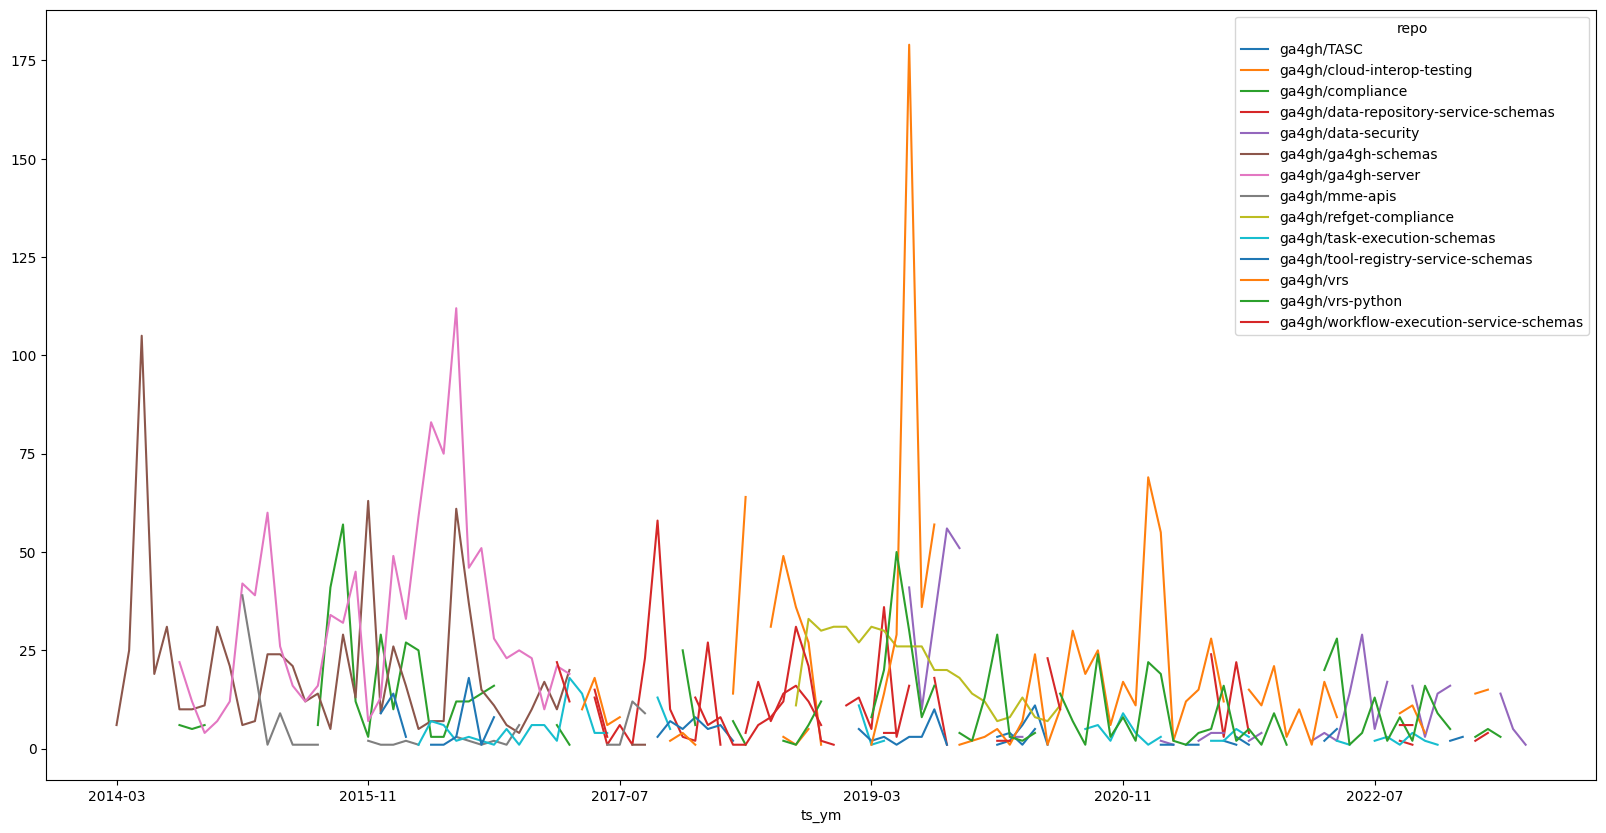

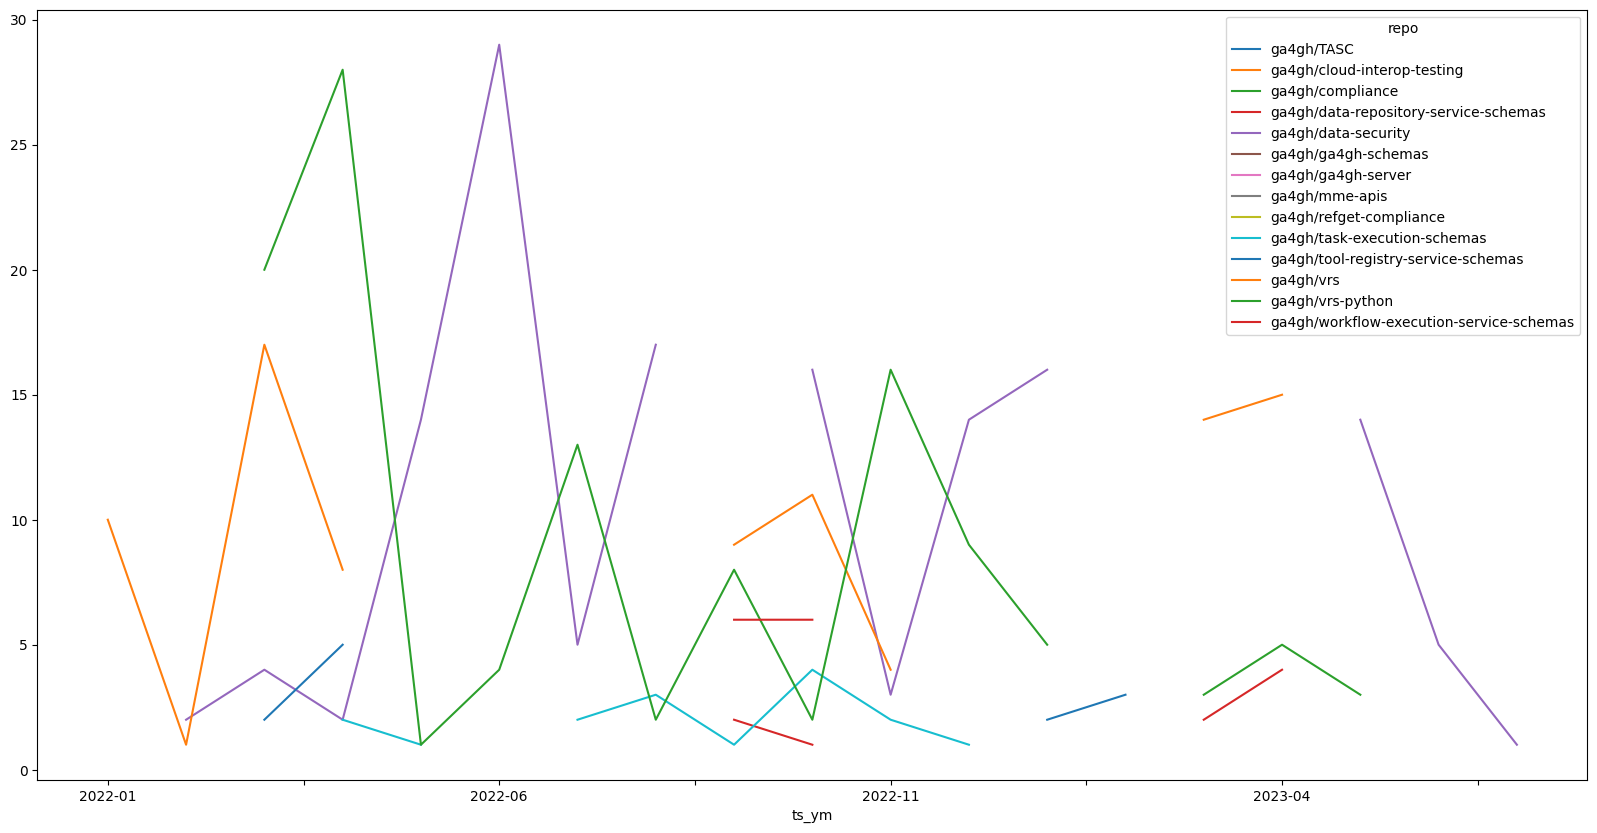

In [65]:
plot_df.plot(figsize=(20,10))
plot_df["2022-01":"2023:09"].plot(figsize=(20,10))

# Commiter Stats

In [ ]:
df_author = commits.groupby(["author_email"], as_index=False).agg(
    min_ts = pd.NamedAgg(column="ts", aggfunc=min),
    num_commits = pd.NamedAgg(column="repo", aggfunc=len),
    num_uniq_repos = pd.NamedAgg(column="repo", aggfunc=pd.Series.nunique)
)
df_author["age"] = now - df_author["min_ts"]
df_author.insert(2, "age", df_author.pop("age"))
df_author

,author_email,min_ts,age,num_commits,num_uniq_repos
0,102165525+wesleygoar@users.noreply.github.com,2022-04-18 10:04:39-05:00,475 days 05:44:32.433477,5,1
1,133602264+bea-amos@users.noreply.github.com,2023-08-02 12:46:33+01:00,4 days 09:02:38.433477,1,1
2,25033562+helensch@users.noreply.github.com,2019-06-09 19:26:19+01:00,1519 days 02:22:52.433477,10,1
3,27856297+dependabot-preview[bot]@users.noreply...,2019-07-11 11:00:30-04:00,1487 days 05:48:41.433477,7,1
4,31826250+david-xliu@users.noreply.github.com,2019-09-12 11:57:20-04:00,1424 days 04:51:51.433477,28,1
...,...,...,...,...,...
273,wesley.goar@nationwidechildrens.org,2022-03-28 15:21:27-05:00,496 days 00:27:44.433477,18,1
274,yasasvini.puligundla@ga4gh.org,2021-09-24 17:00:21-04:00,680 days 23:48:50.433477,170,10
275,yeoldefortran@gmail.com,2014-12-05 15:47:57-05:00,3166 days 00:01:14.433477,9,1
276,ypriverol@gmail.com,2018-11-26 20:28:33+00:00,1714 days 00:20:38.433477,1,1


In [ ]:
df_author.sort_values(by="num_commits", ascending=False).head(20)

,author_email,min_ts,age,num_commits,num_uniq_repos
127,jeremy.adams@ga4gh.org,2019-07-11 15:44:04-04:00,1487 days 01:05:07.433477,933,31
221,reecehart@gmail.com,2015-10-26 16:23:59-07:00,2840 days 21:25:12.433477,823,5
110,ian.fore@nih.gov,2020-08-11 09:27:24-04:00,1090 days 07:21:47.433477,560,4
14,Alex.Wagner@nationwidechildrens.org,2020-08-18 17:08:09-04:00,1082 days 23:41:02.433477,433,12
73,david@resium.com,2015-12-09 15:35:57-08:00,2796 days 21:13:14.433477,432,6
263,travis@travis-ci.org,2018-09-28 09:33:02+00:00,1773 days 11:16:09.433477,422,1
119,james.a.eddy@gmail.com,2018-02-08 12:47:46-08:00,2005 days 00:01:25.433477,392,6
72,danny.colligan@gmail.com,2015-01-15 09:36:58-08:00,3125 days 03:12:13.433477,355,6
130,jk@well.ox.ac.uk,2014-08-12 17:23:51+01:00,3281 days 04:25:20.433477,268,3
51,briandoconnor@gmail.com,2016-04-05 14:59:37-04:00,2679 days 01:49:34.433477,202,8
